In [1]:
import pandas as pd
import numpy as np
import _pickle as cPickle
import gzip
from collections import OrderedDict
from stock_helper import *
from stats import *
from imp import reload
import stock_helper
import stats
reload(stock_helper)
reload(stats) # 重新载入模块

<module 'stats' from 'F:\\bigdata\\my_code\\stats.py'>

In [2]:
# 警告过滤
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

8

In [4]:
# 函数主要用于实现并行计算，加速python算法
import functools
import dask
from dask import compute, delayed
def parLapply(CORE_NUM, iterable, func, *args, **kwargs): # 函数名（CPU核心数目，文件列表，函数，参数1，参数2...，对象1=参数a，对象2=参数b...）
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(func, *args, **kwargs)
        result = compute([delayed(f_par)(item) for item in iterable])[0]
    return result

In [5]:
# 加载数据函数load
def load(path):
    with gzip.open(path, 'rb', compresslevel=1) as file_object:
        raw_data = file_object.read()
    return cPickle.loads(raw_data)

In [6]:
# 保存数据函数save
def save(data, path):
    serialized = cPickle.dumps(data) # 将data对象序列化
    with gzip.open(path, 'wb', compresslevel=1) as file_object: # 以写二进制的模式打开文件
        file_object.write(serialized) # 将序列化的对象写入文件

In [7]:
HEAD_PATH = 'F:/BigData/data'
DATA_PATH = HEAD_PATH + '/stock pkl/'
SAVE_PATH = 'F:/BigData/data'
product_list = ["600276", "600535"] # 防止运行时间过长，只挑选两个股票品种

In [8]:
# 值得注意的是fcum函数中有shift(-n)[:-n]，也就是说因变量是未来的收益率
def fcum(x, n, fill=0):
    return pd.Series(data=cum(pd.concat((x, pd.Series(np.repeat(fill, n))), ignore_index=True), n).shift(-n)[:-n].values, index=x.index)

# ret.period

In [9]:
class foctor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values

In [10]:
y = foctor_ret_period()

In [11]:
for product in product_list:
    create_signal_path(y, product,SAVE_PATH)

F:/BigData/data/tmp pkl/600276/ret.1024
F:/BigData/data/tmp pkl/600276/ret.2048
F:/BigData/data/tmp pkl/600276/ret.4096
F:/BigData/data/tmp pkl/600535/ret.1024
F:/BigData/data/tmp pkl/600535/ret.2048
F:/BigData/data/tmp pkl/600535/ret.4096


In [12]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y, product=product, HEAD_PATH=SAVE_PATH,n=8)

Wall time: 22.5 s


# ret.period.004  
以下因子运用vanish_thre过滤极端值

# 阈值 0.1 0.04 

In [13]:
# 作者过滤极端值的方式本人并不苟同
# def vanish_thre(x, thre):
#     x[np.abs(x)>thre] = 0
#     return x
# 所以我改一下
def vanish_thre(x, thre):
    x[x>thre] = thre
    x[x<-thre] = -thre
    return x
# 改完后效果依然不好

# >0.04 =0.04
# <-0.04 =-0.04

In [14]:
class foctor_ret_period_004(factor_template):
    factor_name = "ret.period.004"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.041).values

In [15]:
y4 = foctor_ret_period_004()

In [16]:
for product in product_list:
    create_signal_path(y4, product, SAVE_PATH)

F:/BigData/data/tmp pkl/600276/ret.1024.004
F:/BigData/data/tmp pkl/600276/ret.2048.004
F:/BigData/data/tmp pkl/600276/ret.4096.004
F:/BigData/data/tmp pkl/600535/ret.1024.004
F:/BigData/data/tmp pkl/600535/ret.2048.004
F:/BigData/data/tmp pkl/600535/ret.4096.004


In [17]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y4, product=product, HEAD_PATH=SAVE_PATH, n=8)

Wall time: 22.1 s


# ret.period.002

In [18]:
class foctor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values

In [19]:
y2 = foctor_ret_period_002()

In [20]:
for product in product_list:
    create_signal_path(y2, product, SAVE_PATH)

F:/BigData/data/tmp pkl/600276/ret.1024.002
F:/BigData/data/tmp pkl/600276/ret.2048.002
F:/BigData/data/tmp pkl/600276/ret.4096.002
F:/BigData/data/tmp pkl/600535/ret.1024.002
F:/BigData/data/tmp pkl/600535/ret.2048.002
F:/BigData/data/tmp pkl/600535/ret.4096.002


In [21]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y2, product=product, HEAD_PATH=SAVE_PATH,n=8)

Wall time: 21.2 s


# ret.period.001

In [22]:
class foctor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values

In [23]:
y1 = foctor_ret_period_001()

In [24]:
for product in product_list:
    create_signal_path(y1, product, SAVE_PATH)

F:/BigData/data/tmp pkl/600276/ret.1024.001
F:/BigData/data/tmp pkl/600276/ret.2048.001
F:/BigData/data/tmp pkl/600276/ret.4096.001
F:/BigData/data/tmp pkl/600535/ret.1024.001
F:/BigData/data/tmp pkl/600535/ret.2048.001
F:/BigData/data/tmp pkl/600535/ret.4096.001


In [25]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y1, product=product, HEAD_PATH=SAVE_PATH, n=8)

Wall time: 20.4 s


In [26]:
data1 = load("F:/BigData/data/tmp pkl/600276/ret.4096.001/2016.pkl")
print(data1)
print(len(data1))

[-0.011      -0.011      -0.011      ...  0.00044024  0.
  0.        ]
646835


In [27]:
import matplotlib.pyplot as plt

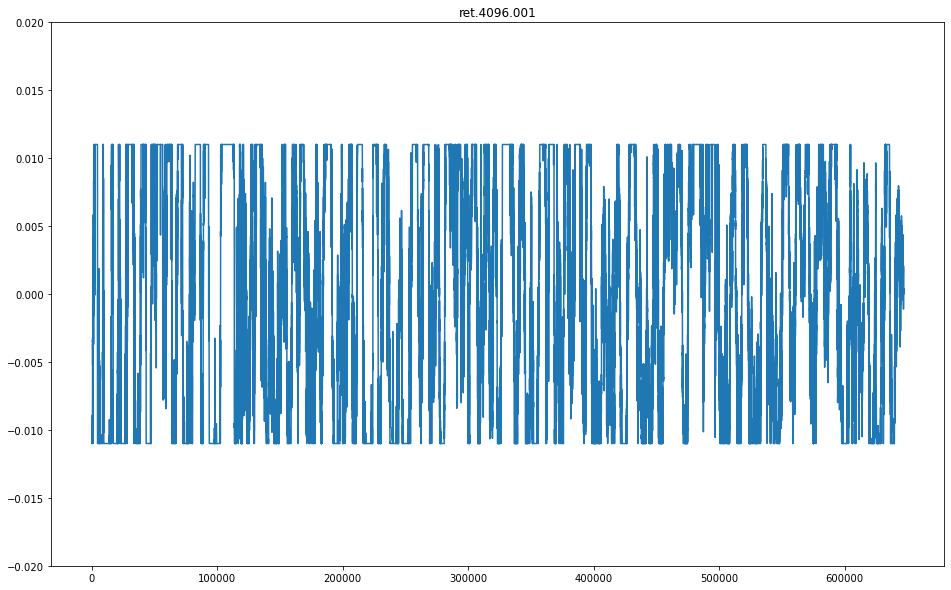

In [28]:
plt.figure(1, (16, 10))
plt.title("ret.4096.001")
plt.plot(data1)
plt.ylim(-0.02, 0.02)
plt.show()

In [29]:
data2 = load("F:/BigData/data/tmp pkl/600276/ret.4096.002/2016.pkl")
print(data2)
print(len(data2))

[-0.021      -0.021      -0.021      ...  0.00044024  0.
  0.        ]
646835


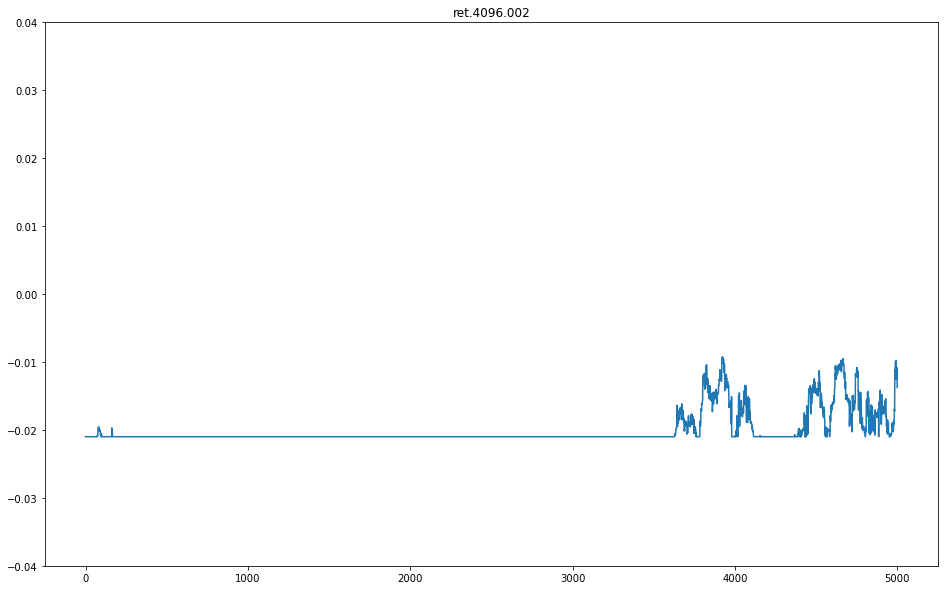

In [30]:
plt.figure(1, (16, 10))
plt.title("ret.4096.002")
plt.plot(data2[10000:15000])
plt.ylim(-0.04, 0.04)
plt.show()

In [31]:
data3 = load("F:/BigData/data/tmp pkl/600276/nr.4096/2016.pkl")
print(data3)
print(len(data3))

[ 0.00000000e+00  1.00000000e+00 -9.58671107e-01 ...  2.81964235e-05
  4.97186210e-04  4.97186210e-04]
646835
